In [1]:
import sys
sys.path.insert(1, '/ai/gno/CODE/GPNO/')

import yaml
import torch
import matplotlib.pyplot as plt
import os.path as osp

from trainers.builder import *
from datasets import NavierStokesDataset

from matplotlib.patches import Ellipse
import numpy as np

from tqdm import tqdm

In [2]:
def vis_gaussian(mu, sigma, weight, ax, factor=1):
    mu = mu.squeeze(0)
    sigma = sigma.squeeze(0)

    mu = mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    weight = weight.cpu().detach().numpy()
    N, G, d = mu.shape

    sample_idx = np.arange(N)
    sample_idx = sample_idx[::factor]

    for n in tqdm(sample_idx):
        # normalize weights
        w_n = np.abs(weight) + 1e-6
        w_n = np.ones_like(w_n)
        w_n = w_n / np.sum(w_n)  # (G,)

        mu_n = mu[n]  # (G,2)
        sigma_n = sigma[n]  # (G,2)

        # 融合中心
        mu_fused = (w_n[:,None] * mu_n).sum(axis=0)  # (2,)

        # 融合尺度
        sigma_fused = (w_n[:,None] * (sigma_n**2 + (mu_n - mu_fused)**2)).sum(axis=0)  # (2,)

        width = np.sqrt(sigma_fused[0]) * 0.05
        height = np.sqrt(sigma_fused[1]) * 0.05
        angle = 0

        ellipse = Ellipse(
            xy=(mu_fused[1], mu_fused[0]),
            width=width,
            height=height,
            angle=angle,
            edgecolor='red',
            facecolor='none',
            lw=1,
            alpha=0.8
        )
        ax.add_patch(ellipse)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('Predicted u(x) with Gaussian Ellipses')
    plt.show()

In [3]:
ns_set = NavierStokesDataset(
    data_path="/ai/gno/DATA/ns/ns_V1e-5_N1200_T20.mat",
    sample_factor=1,
    in_t=1,
    out_t=1,
    duration_t=10,
    train_batchsize=1,
    eval_batchsize=1,
    train_ratio=0.8,
    valid_ratio=0.1,
    test_ratio=0.1,
    normalize=True,
    normalizer_type='PGN',
)

Loading processed data from  /ai/gno/DATA/ns/ns_V1e-5_N1200_T20_processed.pt


In [4]:
# gs_dir = '/ai/gno/CODE/GPNO/logs/NavierStokes/05_07/GaussianField_22_10_07' # 1
gs_dir = '/ai/gno/CODE/GPNO/logs/NavierStokes/05_07/GaussianField_22_35_21' # 8
# gs_dir = '/ai/gno/CODE/GPNO/logs/NavierStokes/05_06/GaussianField_22_44_08' # 128
gs_args_path = osp.join(gs_dir, 'config.yaml')
gs_path = osp.join(gs_dir, 'best_model.pth')
gs_args = yaml.load(open(gs_args_path, 'r'), Loader=yaml.FullLoader)
gs = GSTrainer(gs_args).build_model(gs_args)
gs.load_state_dict(torch.load(gs_path))
gs.cuda()
gs.eval()

GaussianField(
  (encoder): GaussianEncoder(
    (mlp_mu): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
    )
    (mlp_sigma): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
      (3): Softplus(beta=1.0, threshold=20.0)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): GaussianDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

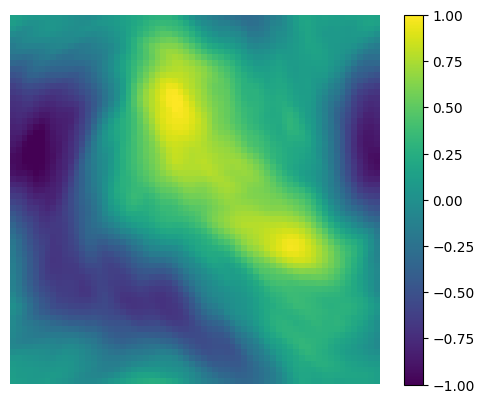

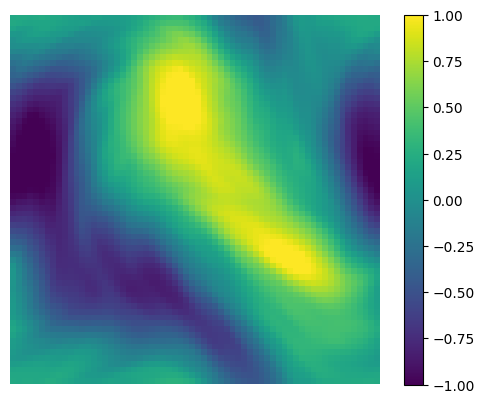

In [6]:
vis_x = ns_set.test_dataset.x[128:129]
vis_y = ns_set.test_dataset.y[128:129]

# vis_x = ns_set.test_dataset.x[38:39]
# vis_y = ns_set.test_dataset.y[38:39]

# vis_x = ns_set.test_dataset.x[28:29]
# vis_y = ns_set.test_dataset.y[28:29]

# plt.figure(dpi=1000)

x = ns_set.test_dataset.x_normalizer.decode(vis_x[..., -1:])
heatmap = plt.imshow(x.reshape(64,64), cmap='viridis', interpolation='nearest', origin='lower', vmin=-1, vmax=1)
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

y = ns_set.test_dataset.y_normalizer.decode(vis_y[..., -1:])
heatmap = plt.imshow(y.reshape(64,64), cmap='viridis', interpolation='nearest', origin='lower', vmin=-1, vmax=1)
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

vis_y = torch.cat([vis_x[..., :2], vis_y], dim=-1)

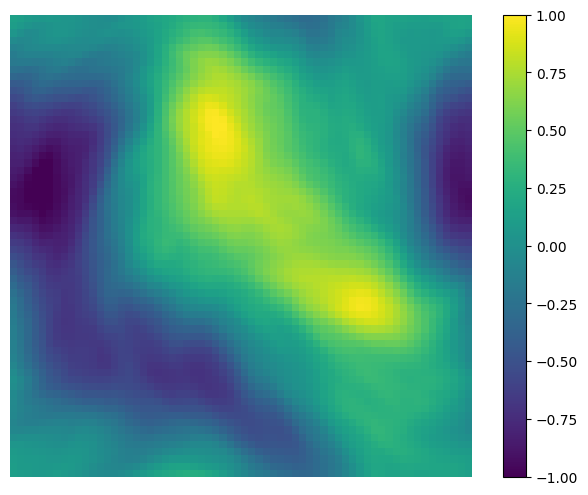

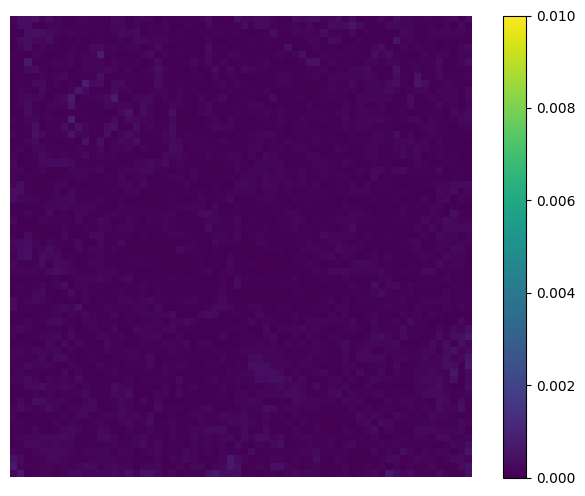

100%|██████████| 4096/4096 [00:10<00:00, 406.14it/s]


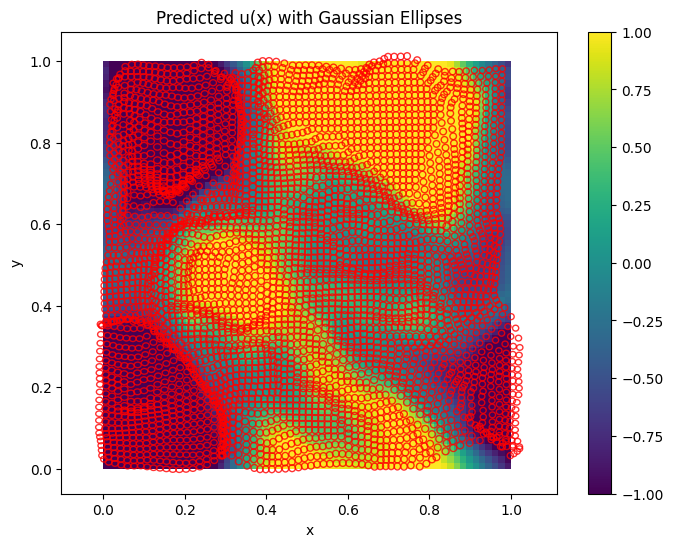

In [6]:
pred_x = gs(vis_x.cuda())
pred_x = ns_set.test_dataset.x_normalizer.decode(pred_x)
pred_x = pred_x.cpu().detach().reshape(64, 64)
# plt.figure(dpi=1000)
fig, ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(pred_x, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower')
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

x = ns_set.test_dataset.x_normalizer.decode(vis_x[..., -1:])
error = torch.abs(pred_x.reshape(64,64) - x.reshape(64, 64))
# plt.figure(dpi=1000)
fig, ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(error, cmap='viridis', interpolation='nearest', vmin=0, vmax=0.01, origin='lower')
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

pred_x = gs(vis_x.cuda()).cpu().detach().reshape(64, 64)
mu, sigma, weight = gs.encode_gaussian(vis_x.cuda())
fig, ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(pred_x, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower', extent=[0.0, 1.0, 0.0, 1.0])
plt.colorbar(heatmap)
vis_gaussian(mu, sigma, weight, ax, factor=1)

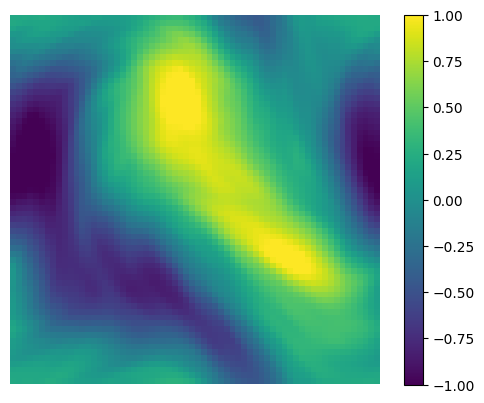

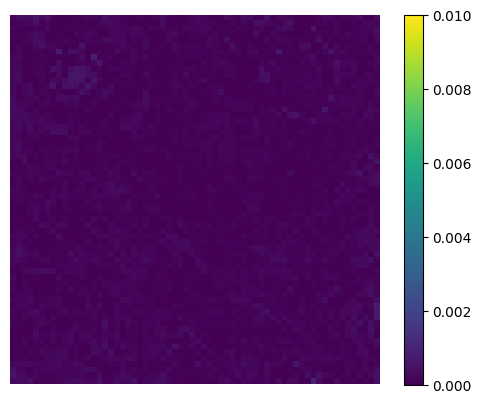

  5%|▌         | 215/4096 [00:00<00:09, 421.17it/s]

100%|██████████| 4096/4096 [00:10<00:00, 401.08it/s]


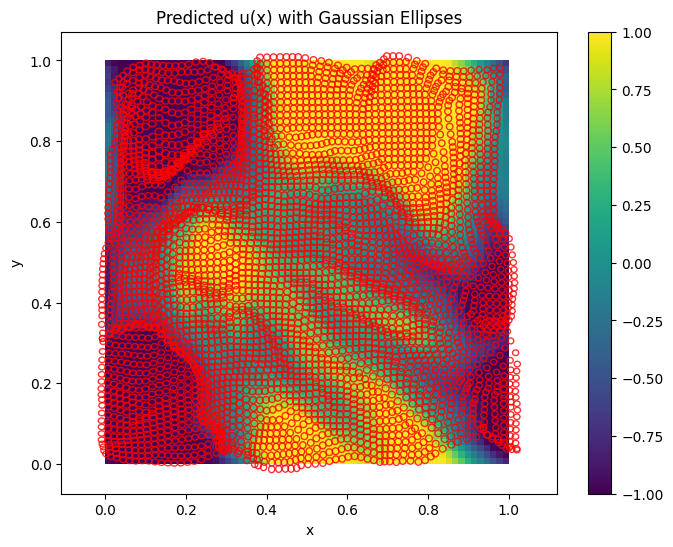

In [7]:
pred_y = gs(vis_y.cuda())
pred_y = ns_set.test_dataset.y_normalizer.decode(pred_y)
pred_y = pred_y.cpu().detach().reshape(64, 64)
heatmap = plt.imshow(pred_y, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower')
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

y = ns_set.test_dataset.y_normalizer.decode(vis_y[..., -1:])
error = torch.abs(pred_y.reshape(64,64) - y.reshape(64, 64))
# plt.figure(dpi=1000)
heatmap = plt.imshow(error, cmap='viridis', interpolation='nearest', vmin=0, vmax=0.01, origin='lower', extent=[0.0, 1.0, 0.0, 1.0])
plt.axis("off")
plt.colorbar(heatmap)
plt.show()

mu, sigma, weight = gs.encode_gaussian(vis_y.cuda())
pred_y = gs(vis_y.cuda()).cpu().detach().reshape(64, 64)
fig, ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(pred_y, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1, origin='lower', extent=[0.0, 1.0, 0.0, 1.0])
plt.colorbar(heatmap)
vis_gaussian(mu, sigma, weight, ax)

In [8]:
from utils.loss import LpLoss

crit = LpLoss(p=2, size_average=True)

x_mu, x_sigma, weight = gs.encode_gaussian(vis_x.cuda())
y_mu, y_sigma, weight = gs.encode_gaussian(vis_y.cuda())

crit(x_mu, y_mu), crit(x_sigma, y_sigma)

(tensor(0.0639, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1195, device='cuda:0', grad_fn=<MeanBackward0>))

In [7]:
import scipy.io as sio

raw_data = sio.loadmat("/ai/gno/DATA/ns/ns_V1e-5_N1200_T20.mat")

In [9]:
raw_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'a', 'u', 't'])

In [14]:
raw_data['u'].shape, raw_data['a'].shape, raw_data['t'].shape

((1200, 64, 64, 20), (1200, 64, 64), (1, 20))

In [15]:
raw_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'a', 'u', 't'])